### set folder_name and day session to analyze

In [11]:
name = 'ANM3'
session = '20240215_d3'

### imports

In [12]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [13]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscriminationData/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, arduino, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

respMTX shape: (74, 7)
MTXTrialType shape: (1, 1)
number of trials: 74


In [14]:
open(leverdata_matfile)

<_io.TextIOWrapper name='../Data_Copy/LeverData/ANM3/LeverData_ANM3_20240215_d3.mat' mode='r' encoding='UTF-8'>

For mac:

In [15]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANM3/PreprocessLeverData_ANM3_20240215_d3/: File exists


For windows:

In [16]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANM3/PreprocessLeverData_ANM3_20240215_d3/: File exists


preview trials

In [17]:
respMTX.shape

(74, 7)

In [18]:
respMTX_shape = respMTX.shape[0]
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(np.hstack((respMTX[1:respMTX_shape, 1:2]-respMTX[0:respMTX_shape-1, 1:2], np.array([np.linspace(0, respMTX_shape-2, respMTX_shape-1)]).transpose())))

[[9.195532 0.000000]
 [15.108009 1.000000]
 [10.092166 2.000000]
 [8.318223 3.000000]
 [15.239159 4.000000]
 [6.104080 5.000000]
 [15.368405 6.000000]
 [7.158558 7.000000]
 [5.828647 8.000000]
 [6.081849 9.000000]
 [15.997165 10.000000]
 [11.717166 11.000000]
 [12.175736 12.000000]
 [15.918995 13.000000]
 [6.630398 14.000000]
 [12.048088 15.000000]
 [12.735337 16.000000]
 [12.583647 17.000000]
 [11.365012 18.000000]
 [11.171709 19.000000]
 [11.024667 20.000000]
 [16.072432 21.000000]
 [13.001769 22.000000]
 [12.571035 23.000000]
 [12.136021 24.000000]
 [12.985415 25.000000]
 [10.009159 26.000000]
 [16.333467 27.000000]
 [15.824634 28.000000]
 [13.223223 29.000000]
 [15.145526 30.000000]
 [16.598225 31.000000]
 [15.576724 32.000000]
 [15.762425 33.000000]
 [13.403863 34.000000]
 [15.434066 35.000000]
 [15.040833 36.000000]
 [16.254974 37.000000]
 [17.057299 38.000000]
 [12.382458 39.000000]
 [16.182156 40.000000]
 [10.617429 41.000000]
 [15.722720 42.000000]
 [13.954820 43.000000]
 [16.

### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [19]:
!./preprocess_leverdata/leverdata2binary {output_folder} {leverdata_matfile} 502721

leverdata from .mat size: 67028828,67028828
leverdata from .mat rank: 2
leverdata vector size: 67028828
leverdata vector with unused rows taken out size: 6045489
vector saved to .bin file ../Data_Copy/AnalysisData/ANM3/PreprocessLeverData_ANM3_20240215_d3/full.bin
finished a trialITI: 556726 index:0 trialITI length: 54005 samples = ~9s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM3/PreprocessLeverData_ANM3_20240215_d3/trial0.bin
finished a trialITI: 645451 index:1 trialITI length: 88725 samples = ~15s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM3/PreprocessLeverData_ANM3_20240215_d3/trial1.bin
finished a trialITI: 704720 index:2 trialITI length: 59269 samples = ~10s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM3/PreprocessLeverData_ANM3_20240215_d3/trial2.bin
finished a trialITI: 753570 index:3 trialITI length: 48850 samples = ~8s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM3/PreprocessLeverData_ANM3_20240215_d3/trial3.bin
finished a trialITI: 

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [20]:
num_trials = 73

### Look at sampling rates for the `lever_data`

In [21]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  9.195532199999999
Number of leverdata samples:  54005
Estimated freq:  5872.960784151243
Trial  1
Duration in MATLAB seconds from respMTX:  15.108008900000002
Number of leverdata samples:  88725
Estimated freq:  5872.71298205285
Trial  2
Duration in MATLAB seconds from respMTX:  10.092166000000002
Number of leverdata samples:  59269
Estimated freq:  5872.773000364836
Trial  3
Duration in MATLAB seconds from respMTX:  8.318223399999994
Number of leverdata samples:  48850
Estimated freq:  5872.64823880542
Trial  4
Duration in MATLAB seconds from respMTX:  15.239159300000004
Number of leverdata samples:  89495
Estimated freq:  5872.69928991424
Trial  5
Duration in MATLAB seconds from respMTX:  6.104080099999997
Number of leverdata samples:  35847
Estimated freq:  5872.629358189453
Trial  6
Duration in MATLAB seconds from respMTX:  15.368404999999996
Number of leverdata samples:  90255
Estimated freq:  5872.76298353668
Trial  7
Duration in

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 50 Hz

Assuming electrical noise will be around 60 Hz

In [22]:
cutoff_frequency = 50
butterworth_filter_leverdata(output_folder, num_trials, cutoff_frequency)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [23]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [24]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [25]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

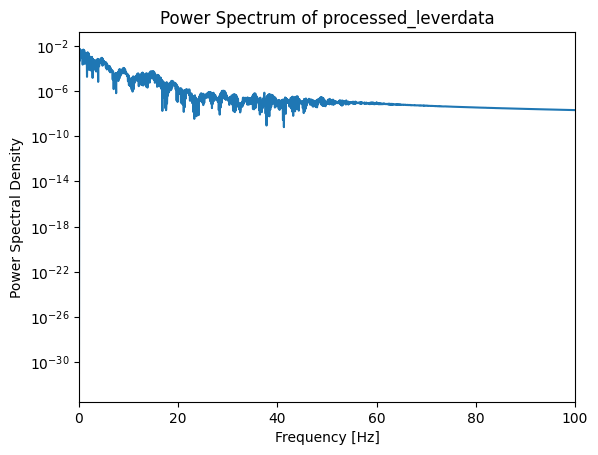

In [26]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)